In [ ]:
import sys
import numpy
import matplotlib
import skimage
import tensorflow as tf
import cv2
from skimage.transform import resize, rescale
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from skimage import measure
#import measure.compare_ssim as ssim
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [ ]:
def train_high(path, size, scale):
    names = sorted(os.listdir(path))
    print(len(names))
    data = []
    for name in names:
        fpath = os.path.join(path, name)
        img = cv2.imread(fpath)
        img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255   # y is the luma.
        shape = img.shape
        data.append(img) # no. of images  #900 ---->(w,h)
    data = np.array(data)   # (no. of image, w, h)
    return data

In [ ]:
Xtrain_high = train_high('/content/drive/MyDrive/Colab Notebooks/Master_Thesis/DATASET/train_dataset/DIV2K_DATASET', (256, 256), 2)

900


In [ ]:
Xtrain_high.shape

(900, 256, 256)

In [ ]:
def train_low(path,size,scale):
    names = sorted(os.listdir(path)) # get  all items  in path
    print(len(names)) # print no. of img
    data = []
    for name in names:
        fpath = os.path.join(path, name)  # add name  of img to the path
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size),cv2.INTER_CUBIC)  # downsample bicubic
        img = cv2.resize(img, ((size*scale),(size*scale)),cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255   # y is the luma
        shape = img.shape
        data.append(img)
    data = np.array(data)
    return data

In [ ]:
y_train_low = train_low('/content/drive/MyDrive/Colab Notebooks/Master_Thesis/DATASET/train_dataset/DIV2K_DATASET',128,2)


900


In [ ]:
y_train_low.shape

(900, 256, 256)

In [ ]:
# define the SRCNN model
def model():

    # define model type
    SRCNN = Sequential()

    # add model layers  #    (1392, 2040, 3)
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True, input_shape=(None,None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True))

    # define optimizer
    adam = Adam(lr=0.003)

    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])

    return SRCNN

In [ ]:
srcnn = model()
srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'high resolution ')

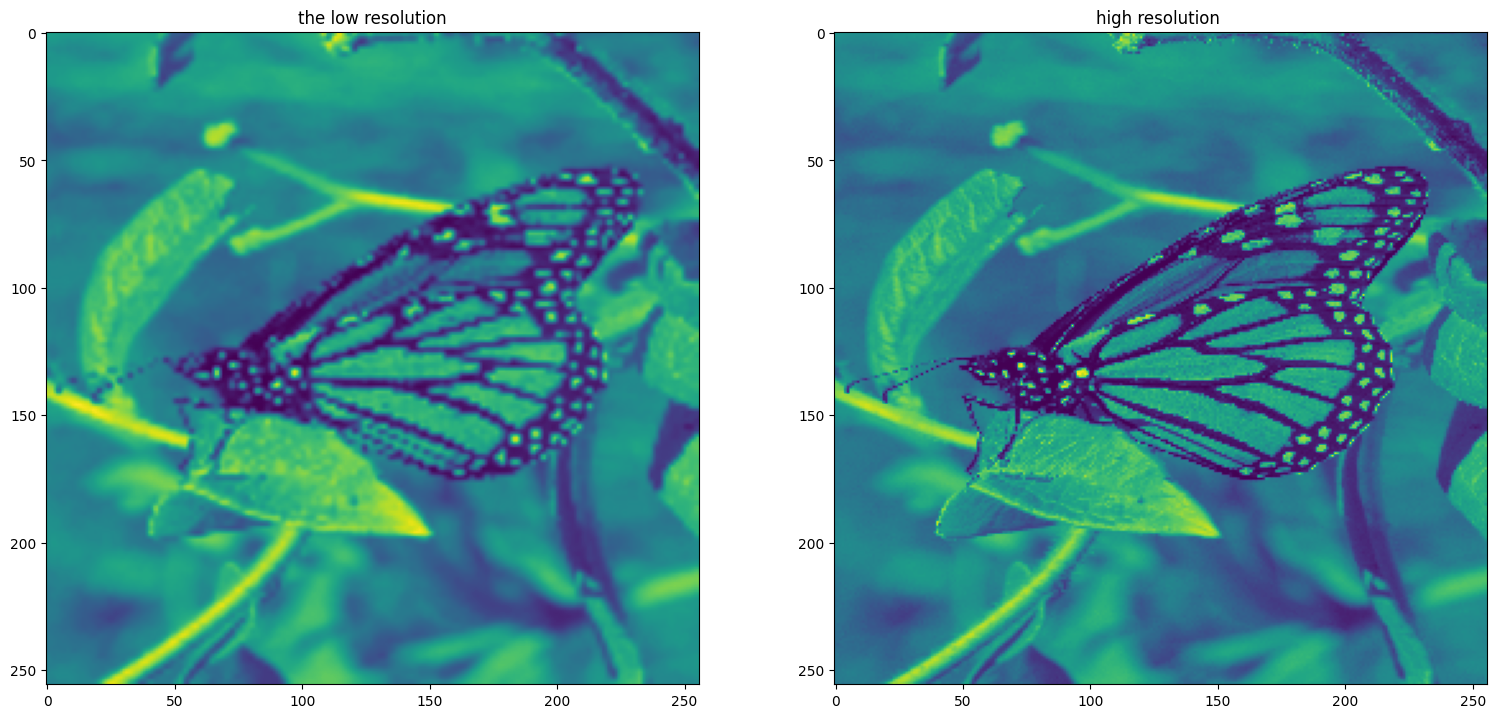

In [ ]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(y_train_low[5])
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(Xtrain_high[5])
plt.title("high resolution ")

In [ ]:
low= numpy.zeros((y_train_low.shape[0], y_train_low.shape[1], y_train_low.shape[2], 1), dtype=float)
low[:, :, :, 0]=y_train_low[:, :, :].astype(float)
low.shape

(900, 256, 256, 1)

In [ ]:
high= numpy.zeros((Xtrain_high.shape[0], Xtrain_high.shape[1], Xtrain_high.shape[2], 1), dtype=float)
high[:, :, :, 0]=Xtrain_high[:, :, :].astype(float)
high.shape

(900, 256, 256, 1)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [ ]:
history=srcnn.fit(low, high, batch_size=32, validation_split=0.2, shuffle=True, epochs=100,callbacks=[callback])

Epoch 1/100
23/23 [==============================] - 33s 572ms/step - loss: 0.0398 - accuracy: 0.0121 - val_loss: 0.0171 - val_accuracy: 0.0101
Epoch 2/100
23/23 [==============================] - 6s 274ms/step - loss: 0.0155 - accuracy: 0.0124 - val_loss: 0.0130 - val_accuracy: 0.0102
Epoch 3/100
23/23 [==============================] - 6s 273ms/step - loss: 0.0127 - accuracy: 0.0125 - val_loss: 0.0115 - val_accuracy: 0.0102
Epoch 4/100
23/23 [==============================] - 6s 277ms/step - loss: 0.0118 - accuracy: 0.0125 - val_loss: 0.0109 - val_accuracy: 0.0102
Epoch 5/100
23/23 [==============================] - 6s 279ms/step - loss: 0.0112 - accuracy: 0.0126 - val_loss: 0.0104 - val_accuracy: 0.0102
Epoch 6/100
23/23 [==============================] - 6s 280ms/step - loss: 0.0109 - accuracy: 0.0126 - val_loss: 0.0103 - val_accuracy: 0.0102
Epoch 7/100
23/23 [==============================] - 6s 281ms/step - loss: 0.0107 - accuracy: 0.0126 - val_loss: 0.0102 - val_accuracy: 0.010

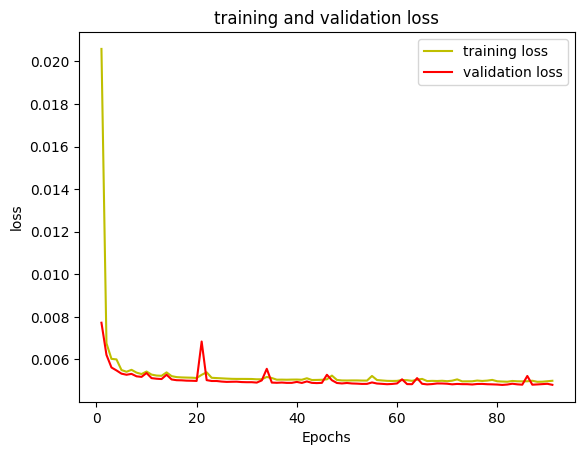

In [ ]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Master_Thesis/SRCNN/Results/x2/Training_&_Validation_LOSS.png")
plt.show()


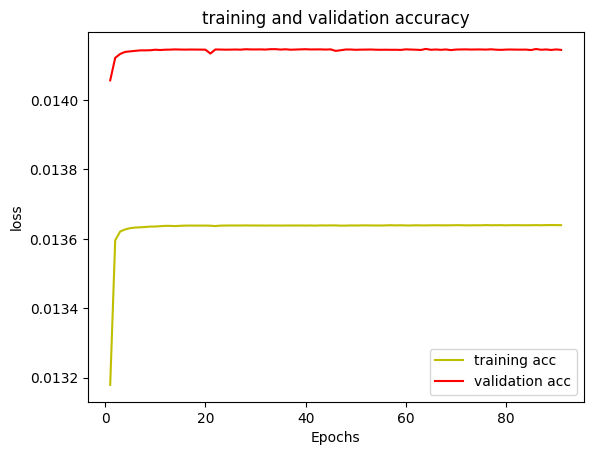

In [ ]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Master_Thesis/SRCNN/Results/x2/Training_&_Validation_ACCURACY_flickr8091.png")
plt.show()

In [ ]:
srcnn.save('/content/drive/MyDrive/Colab Notebooks/Master_Thesis/SRCNN/SRCNNx2/srcnn_model_2x.h5')